In [80]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
'''
    Copyright 2017 Kevin Grogan

    This file is part of StanShock.

    StanShock is free software: you can redistribute it and/or modify
    it under the terms of the GNU Lesser General Public License as published by
    the Free Software Foundation, either version 3 of the License.

    StanShock is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU Lesser General Public License for more details.

    You should have received a copy of the GNU Lesser General Public License
    along with StanShock.  If not, see <https://www.gnu.org/licenses/>.
'''
from pathlib import Path
from typing import Any, Dict, List, Optional, Sequence, Tuple

import cantera as ct
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

from StanShock.stanShock import stanShock

def _find_project_dir_from_cwd() -> Path:
    """Locate repository root from current working directory (not __file__)."""
    cwd = Path.cwd().resolve()
    for candidate in (cwd, *cwd.parents):
        if (candidate / "StanShock").exists() and (candidate / "data").exists():
            return candidate
    raise RuntimeError("Could not locate project root from current working directory.")


PROJECT_DIR = _find_project_dir_from_cwd()
DEFAULT_RESULTS_DIR = PROJECT_DIR / "examples/validation/SOD + BL Simulation Output"


def _shock_metrics_from_probe(
    t: np.ndarray,
    p: np.ndarray,
    baseline_pressure: float,
    rise_fraction: float = 0.03,
    baseline_fraction: float = 0.05,
) -> Tuple[float, float, float]:
    """
    Extract incident-shock arrival and strength from a probe trace.

    Shock-capturing logic used here:
    1) Estimate probe baseline pressure from the first ~5% of samples.
    2) Compute an adaptive rise threshold as:
         p_threshold = p_baseline + rise_fraction * (p_max - p_baseline)
       This intentionally allows detection of a *small first step* (incident shock)
       even when a larger reflected-shock jump appears later.
    3) Pick the first time index where pressure crosses p_threshold.
    4) Interpolate threshold-crossing time between adjacent samples.
    5) Compute shock pressure as the short-window mean right after crossing.
    """
    if len(t) < 10:
        raise RuntimeError("Probe trace is too short to determine shock metrics.")

    p_baseline, p_max, p_threshold = _probe_threshold_details(
        p, rise_fraction=rise_fraction, baseline_fraction=baseline_fraction
    )
    p_dynamic = float(p_max - p_baseline)
    if p_dynamic <= 0.0:
        arrival_time = float(t[0])
        shock_pressure = p_baseline
        attenuation_metric = float(np.log(max(shock_pressure, 1e-12) / baseline_pressure))
        return arrival_time, shock_pressure, attenuation_metric

    crossing = np.where(p >= p_threshold)[0]
    if len(crossing) == 0:
        i_cross = int(np.argmax(np.gradient(p, t)))
        arrival_time = float(t[i_cross])
    else:
        i_cross = int(crossing[0])
        if i_cross > 0 and p[i_cross] != p[i_cross - 1]:
            # Interpolate threshold-crossing time so the arrival marker matches
            # the plotted threshold criterion (p >= p_threshold) more faithfully.
            frac = (p_threshold - p[i_cross - 1]) / (p[i_cross] - p[i_cross - 1])
            arrival_time = float(t[i_cross - 1] + frac * (t[i_cross] - t[i_cross - 1]))
        else:
            arrival_time = float(t[i_cross])

    i1 = i_cross
    i2 = min(len(p), i_cross + 6)
    shock_pressure = float(np.mean(p[i1:i2]))
    attenuation_metric = float(np.log(shock_pressure / baseline_pressure))
    return arrival_time, shock_pressure, attenuation_metric


def _probe_threshold_details(
    p: np.ndarray,
    rise_fraction: float,
    baseline_fraction: float,
) -> Tuple[float, float, float]:
    """Return (p_baseline, p_max, p_threshold) used by shock thresholding."""
    n0 = max(5, int(baseline_fraction * len(p)))
    p_baseline = float(np.mean(p[:n0]))
    p_max = float(np.max(p))
    p_threshold = float(p_baseline + rise_fraction * (p_max - p_baseline))
    return p_baseline, p_max, p_threshold


# placeholder: branch-reset marker for new PR workflow
def _collect_probe_traces(ssbl: stanShock, n_probes: int) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """Collect raw time/pressure traces for each configured probe."""
    probe_times = []
    probe_pressures = []
    for probe in ssbl.probes[:n_probes]:
        probe_times.append(np.array(probe.t))
        probe_pressures.append(np.array(probe.p))
    return probe_times, probe_pressures




def _extract_shock_metrics_for_all_probes(
    probe_times: Sequence[np.ndarray],
    probe_pressures: Sequence[np.ndarray],
    baseline_pressure: float,
    rise_fraction: float,
    baseline_fraction: float,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Apply single-probe shock capture to each probe trace."""
    arrivals = []
    shock_pressures = []
    attenuation_values = []

    for t_probe, p_probe in zip(probe_times, probe_pressures):
        arrival_t, p_shock, attn = _shock_metrics_from_probe(
            t_probe, p_probe, baseline_pressure, rise_fraction=rise_fraction, baseline_fraction=baseline_fraction
        )
        arrivals.append(arrival_t)
        shock_pressures.append(p_shock)
        attenuation_values.append(attn)

    return np.array(arrivals), np.array(shock_pressures), np.array(attenuation_values)

def postprocess_probe_traces(
    probe_times: Sequence[np.ndarray],
    probe_pressures: Sequence[np.ndarray],
    probe_locations: Sequence[float],
    baseline_pressure: float,
    gas1: Optional[ct.Solution],
    boundary_layer_model: bool,
    rise_fraction: float = 0.03,
    baseline_fraction: float = 0.05,
    sound_speed_a1: Optional[float] = None,
) -> Dict[str, Any]:
    """Post-process probe arrays after single-probe shock capture.

    Note: `_shock_metrics_from_probe` performs the actual shock-capturing algorithm
    for one trace. This function only aggregates those per-probe outputs and fits
    attenuation/speed trends across probe locations.
    """
    x_probe = np.array(probe_locations)
    arrivals, shock_pressures, attenuation_values = _extract_shock_metrics_for_all_probes(
        probe_times=probe_times,
        probe_pressures=probe_pressures,
        baseline_pressure=baseline_pressure,
        rise_fraction=rise_fraction,
        baseline_fraction=baseline_fraction,
    )

    attenuation_rate, attenuation_intercept = np.polyfit(x_probe, attenuation_values, 1)
    x_t_slope, x_t_intercept = np.polyfit(arrivals, x_probe, 1)

    dt_seg = np.diff(arrivals)
    dx_seg = np.diff(x_probe)
    valid_seg = dt_seg > 0.0
    if np.count_nonzero(valid_seg) >= 2:
        x_seg = 0.5 * (x_probe[:-1][valid_seg] + x_probe[1:][valid_seg])
        us_seg = dx_seg[valid_seg] / dt_seg[valid_seg]
        us_attenuation_rate, us_intercept = np.polyfit(x_seg, us_seg, 1)

        a1 = float(sound_speed_a1) if sound_speed_a1 is not None else _gas_sound_speed(gas1)
        ms_seg = us_seg / a1
        ms_attenuation_rate, ms_intercept = np.polyfit(x_seg, ms_seg, 1)

        us_percent_attenuation_rate = 100.0 * us_attenuation_rate / us_intercept if us_intercept != 0.0 else np.nan
    else:
        x_seg = np.array([])
        us_seg = np.array([])
        ms_seg = np.array([])
        us_attenuation_rate = np.nan
        us_intercept = np.nan
        ms_attenuation_rate = np.nan
        ms_intercept = np.nan
        us_percent_attenuation_rate = np.nan

    if boundary_layer_model:
        if np.isfinite(us_attenuation_rate):
            print("Shock-speed attenuation dU_s/dx [(m/s)/m]: %.6f" % us_attenuation_rate)
        else:
            print("Shock-speed attenuation dU_s/dx [(m/s)/m]: unavailable (insufficient valid probe segments)")
        if np.isfinite(us_percent_attenuation_rate):
            print("Percent speed-change attenuation (slope/intercept*100) [%%/m]: %.6f" % us_percent_attenuation_rate)
        else:
            print("Percent speed-change attenuation (slope/intercept*100) [%%/m]: unavailable")
        if np.isfinite(ms_attenuation_rate):
            print("Mach attenuation dM_s/dx [1/m]: %.6f" % ms_attenuation_rate)
        else:
            print("Mach attenuation dM_s/dx [1/m]: unavailable (insufficient valid probe segments)")

    return {
        "probe_locations": x_probe,
        "probe_arrival_times": arrivals,
        "probe_shock_pressures": shock_pressures,
        "probe_attenuation": attenuation_values,
        "attenuation_rate": attenuation_rate,
        "attenuation_intercept": attenuation_intercept,
        "shock_speed_average": x_t_slope,
        "shock_speed_intercept": x_t_intercept,
        "shock_speed_segment_centers": x_seg,
        "shock_speed_segment": us_seg,
        "shock_speed_attenuation_rate": us_attenuation_rate,
        "shock_speed_attenuation_intercept": us_intercept,
        "shock_speed_percent_attenuation_rate": us_percent_attenuation_rate,
        "shock_mach_segment": ms_seg,
        "shock_mach_attenuation_rate": ms_attenuation_rate,
        "shock_mach_attenuation_intercept": ms_intercept,
    }


def reconstruct_probe_traces_from_xt(
    xt_time: np.ndarray,
    xt_x: np.ndarray,
    xt_pressure: np.ndarray,
    probe_locations: Sequence[float],
) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """Reconstruct pressure-time traces at arbitrary x from cached X-t pressure data."""
    xt_time = np.asarray(xt_time)
    xt_x = np.asarray(xt_x)
    p_xt = np.asarray(xt_pressure)

    if xt_time.ndim != 1 or xt_x.ndim != 1:
        raise ValueError("xt_time and xt_x must be one-dimensional arrays")
    if p_xt.ndim != 2:
        raise ValueError("xt_pressure must be a 2D array")

    if p_xt.shape == (len(xt_time), len(xt_x)):
        p_t_x = p_xt
    elif p_xt.shape == (len(xt_x), len(xt_time)):
        p_t_x = p_xt.T
    else:
        raise ValueError(
            "xt_pressure shape must be (n_time, n_x) or (n_x, n_time). "
            f"Received {p_xt.shape}."
        )

    probe_times = [xt_time.copy() for _ in probe_locations]
    probe_pressures = []

    x_min = float(np.min(xt_x))
    x_max = float(np.max(xt_x))
    for x_probe in probe_locations:
        xq = float(np.clip(x_probe, x_min, x_max))
        p_probe = np.array([
            np.interp(xq, xt_x, p_t_x[i, :], left=p_t_x[i, 0], right=p_t_x[i, -1])
            for i in range(len(xt_time))
        ])
        probe_pressures.append(p_probe)

    return probe_times, probe_pressures


def postprocess_probe_file(
    raw_results_file: str,
    rise_fraction: float = 0.03,
    baseline_fraction: float = 0.05,
    probe_locations: Optional[Sequence[float]] = None,
) -> Dict[str, Any]:
    """Load cached results from disk and recompute shock metrics offline.

    If ``probe_locations`` is provided and X-t pressure data exists in the cache,
    probe traces are reconstructed at the new positions from the X-t field.
    """
    with np.load(raw_results_file, allow_pickle=True) as data:
        cached_probe_locations = np.array(data["probe_locations"])
        baseline_pressure = float(data["P1"])
        sound_speed_a1 = float(data["sound_speed_a1"]) if "sound_speed_a1" in data else None

        if probe_locations is not None and all(k in data for k in ("xt_time", "xt_x", "xt_pressure")):
            probe_locations = np.array(probe_locations, dtype=float)
            probe_times, probe_pressures = reconstruct_probe_traces_from_xt(
                data["xt_time"], data["xt_x"], data["xt_pressure"], probe_locations
            )
        else:
            probe_times = [np.array(t) for t in data["probe_t"]]
            probe_pressures = [np.array(p) for p in data["probe_p"]]
            probe_locations = cached_probe_locations

    return postprocess_probe_traces(
        probe_times=probe_times,
        probe_pressures=probe_pressures,
        probe_locations=probe_locations,
        baseline_pressure=baseline_pressure,
        gas1=None,
        boundary_layer_model=True,
        rise_fraction=rise_fraction,
        baseline_fraction=baseline_fraction,
        sound_speed_a1=sound_speed_a1,
    )



def _prepare_results_dir(results_location: Optional[str]) -> Path:
    """Return cache/output directory and ensure it exists."""
    out_dir = DEFAULT_RESULTS_DIR if results_location is None else Path(results_location)
    out_dir.mkdir(parents=True, exist_ok=True)
    return out_dir


def _cache_file_path(results_location: Optional[str]) -> Path:
    """Canonical cached results file path used for post-processing."""
    return _prepare_results_dir(results_location) / "case1_attenuation.npz"

def _gas_sound_speed(gas: ct.Solution) -> float:
    """Return sound speed with compatibility across Cantera versions."""
    if hasattr(gas, "sound_speed"):
        return float(gas.sound_speed)
    if hasattr(gas, "soundspeed"):
        return float(gas.soundspeed)
    gamma = gas.cp_mass / gas.cv_mass
    return float(np.sqrt(gamma * gas.P / gas.density))




def _plot_postprocessed_results(
    probe_times: Sequence[np.ndarray],
    probe_pressures: Sequence[np.ndarray],
    probe_locations: Sequence[float],
    metrics: Dict[str, Any],
    boundary_layer_model: bool,
    rise_fraction: float,
    baseline_fraction: float,
    fontsize: int = 11,
) -> Tuple[Any, Optional[Any]]:
    """Create probe and speed-fit plots from postprocessed data."""
    arrivals = metrics["probe_arrival_times"]
    us_percent_attenuation_rate = metrics["shock_speed_percent_attenuation_rate"]
    x_seg = metrics["shock_speed_segment_centers"]
    us_seg = metrics["shock_speed_segment"]
    us_attenuation_rate = metrics["shock_speed_attenuation_rate"]
    us_intercept = metrics["shock_speed_attenuation_intercept"]

    plt.close("all")
    mpl.rcParams["font.size"] = fontsize

    n_probe_plot = len(probe_locations)
    fig, axes = plt.subplots(n_probe_plot, 1, figsize=(6.2, 2.25 * n_probe_plot + 1.0), sharex=True)
    if n_probe_plot == 1:
        axes = np.array([axes])
    for i in range(n_probe_plot):
        t_probe = np.array(probe_times[i])
        p_probe = np.array(probe_pressures[i])
        axes[i].plot(t_probe * 1000.0, p_probe / 1.0e5, "k", linewidth=1.7)
        axes[i].axvline(arrivals[i] * 1000.0, color="r", linestyle="--", linewidth=1.2, label="shock arrival")
        axes[i].set_ylabel("p [bar]")
        axes[i].set_title("Probe %d at x = %.2f m" % (i + 1, probe_locations[i]))
        p_baseline, p_max, p_threshold = _probe_threshold_details(
            np.array(p_probe), rise_fraction=rise_fraction, baseline_fraction=baseline_fraction
        )
        axes[i].axhline(p_threshold / 1.0e5, color="tab:green", linestyle=":", linewidth=1.1, label="threshold")
        details = (
            f"rise_fraction={rise_fraction:.4f}\n"
            f"baseline_fraction={baseline_fraction:.4f}\n"
            f"p_max={p_max/1e5:.3f} bar\n"
            f"p_baseline={p_baseline/1e5:.3f} bar\n"
            f"p_threshold={p_threshold/1e5:.3f} bar"
        )
        axes[i].text(
            0.99,
            0.02,
            details,
            transform=axes[i].transAxes,
            ha="right",
            va="bottom",
            fontsize=8,
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.75, edgecolor="0.7"),
        )
        axes[i].grid(alpha=0.25)
        axes[i].legend(loc="upper right")
    axes[-1].set_xlabel("t [ms]")
    if boundary_layer_model:
        fig.suptitle(
            "(Boundary Layer ON)\nShock attenuation rate (Shock Speed) [%%/m]: %.6f" % us_percent_attenuation_rate,
            y=0.995,
        )
        fig.tight_layout(rect=[0, 0, 1, 0.96])
    else:
        fig.suptitle("(Boundary Layer OFF)", y=0.995)
        fig.tight_layout(rect=[0, 0, 1, 0.96])

    fig_speed = None
    if len(x_seg) > 0:
        fig_speed = plt.figure(figsize=(6.2, 4.0))
        plt.plot(x_seg, us_seg, "o", color="tab:blue", label="Segment speed")
        if np.isfinite(us_attenuation_rate) and np.isfinite(us_intercept):
            x_fit = np.linspace(np.min(x_seg), np.max(x_seg), 100)
            u_fit = us_attenuation_rate * x_fit + us_intercept
            plt.plot(
                x_fit,
                u_fit,
                "--",
                color="tab:red",
                label=(
                    "Linear fit: $U_s = m x + b$\n"
                    f"m={us_attenuation_rate:.3f} (m/s)/m, b={us_intercept:.3f} m/s"
                ),
            )
        plt.xlabel("Segment center x [m]")
        plt.ylabel("Probed speed U_s [m/s]")
        plt.title("Probed Speed vs Segment Centers")
        plt.grid(alpha=0.25)
        plt.legend(loc="best")
        plt.tight_layout()

    return fig, fig_speed


def postprocess_cached_results(
    results_location: Optional[str] = None,
    probe_locations: Optional[Sequence[float]] = None,
    rise_fraction: float = 0.03,
    baseline_fraction: float = 0.05,
    show_results: bool = True,
    boundary_layer_model: Optional[bool] = None,
) -> Dict[str, Any]:
    """Post-process already-cached CFD results with optional redefined probe locations."""
    cache_file = _cache_file_path(results_location)
    with np.load(cache_file, allow_pickle=True) as data:
        xt_time = np.array(data["xt_time"])
        xt_x = np.array(data["xt_x"])
        xt_pressure = np.array(data["xt_pressure"])
        cached_probe_locations = np.array(data["probe_locations"])
        T1 = float(data["T1"]) if "T1" in data else np.nan
        P1 = float(data["P1"]) if "P1" in data else np.nan
        T4 = float(data["T4"]) if "T4" in data else np.nan
        P4 = float(data["P4"]) if "P4" in data else np.nan
        sound_speed_a1 = float(data["sound_speed_a1"]) if "sound_speed_a1" in data else np.nan
        cached_boundary_layer_model = bool(data["Boundary_Layer_Model"]) if "Boundary_Layer_Model" in data else True

    selected_probe_locations = np.array(probe_locations) if probe_locations is not None else cached_probe_locations
    effective_boundary_layer_model = cached_boundary_layer_model if boundary_layer_model is None else bool(boundary_layer_model)

    metrics = postprocess_probe_file(
        str(cache_file),
        rise_fraction=rise_fraction,
        baseline_fraction=baseline_fraction,
        probe_locations=selected_probe_locations,
    )

    probe_t, probe_p = reconstruct_probe_traces_from_xt(
        xt_time, xt_x, xt_pressure, selected_probe_locations
    )

    fig, fig_speed = _plot_postprocessed_results(
        probe_times=probe_t,
        probe_pressures=probe_p,
        probe_locations=selected_probe_locations,
        metrics=metrics,
        boundary_layer_model=effective_boundary_layer_model,
        rise_fraction=rise_fraction,
        baseline_fraction=baseline_fraction,
    )

    if show_results:
        plt.show()
    else:
        plt.close("all")

    results_dir = _prepare_results_dir(results_location)
    np.savez(
        cache_file,
        probe_locations=metrics["probe_locations"],
        probe_arrival_times=metrics["probe_arrival_times"],
        T1=T1,
        P1=P1,
        T4=T4,
        P4=P4,
        Boundary_Layer_Model=effective_boundary_layer_model,
        probe_shock_pressures=metrics["probe_shock_pressures"],
        probe_attenuation=metrics["probe_attenuation"],
        attenuation_rate=metrics["attenuation_rate"],
        attenuation_intercept=metrics["attenuation_intercept"],
        shock_speed_average=metrics["shock_speed_average"],
        shock_speed_intercept=metrics["shock_speed_intercept"],
        shock_speed_segment_centers=metrics["shock_speed_segment_centers"],
        shock_speed_segment=metrics["shock_speed_segment"],
        shock_speed_attenuation_rate=metrics["shock_speed_attenuation_rate"],
        shock_speed_attenuation_intercept=metrics["shock_speed_attenuation_intercept"],
        shock_speed_percent_attenuation_rate=metrics["shock_speed_percent_attenuation_rate"],
        shock_mach_segment=metrics["shock_mach_segment"],
        shock_mach_attenuation_rate=metrics["shock_mach_attenuation_rate"],
        shock_mach_attenuation_intercept=metrics["shock_mach_attenuation_intercept"],
        xt_time=xt_time,
        xt_x=xt_x,
        xt_pressure=xt_pressure,
        probe_t=np.array(probe_t, dtype=object),
        probe_p=np.array(probe_p, dtype=object),
        probe_rise_fraction=rise_fraction,
        probe_baseline_fraction=baseline_fraction,
        sound_speed_a1=sound_speed_a1,
    )
    fig.savefig(results_dir / "case1_attenuation_probes.png", dpi=200)
    if fig_speed is not None:
        fig_speed.savefig(results_dir / "case1_attenuation_speed_fit.png", dpi=200)

    out = dict(metrics)
    out.update({"xt_time": xt_time, "xt_x": xt_x, "xt_pressure": xt_pressure, "probe_t": probe_t, "probe_p": probe_p})
    return out

def main(
        #PROJECT_DIR / "data/mechanisms/HeliumArgon.xml",
    mech_filename_gas_1: str = "gri30_He.yaml",
    mech_filename_gas_4: str = "gri30_He.yaml",
    show_results: bool = True,
    results_location: Optional[str] = None,
    t_final: float = 30e-3,
    n_x: int = 1000,
    cfl: float = 0.9,
    T1: float = 296.15,
    P1: float = 20000,
    T4: float = 296.15,
    P4: float = 110400,
    X1: Optional[str] = 'H2:4, O2:2, Ar:94', #4PctH2_2PctO2_94PctAr
    X4: Optional[str] = 'He:58.8971, Ar:41.1029', #'He:21.8787, N2:78.1213'
    Boundary_Layer_Model: bool = True,
    probe_locations: Sequence[float] = (0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.47),
    probe_rise_fraction: float = 0.03,
    probe_baseline_fraction: float = 0.05,
    expose_results_to_globals: bool = False,

) -> Dict[str, Any]:
    ct.add_directory(PROJECT_DIR)
    # simulation controls
    tFinal = t_final

    # plotting parameters
    fontsize = 11

    # provided geometry
    DDriven = 122.24/1000 #m
    DDriver = DDriven
    LDriver = 3.96 #m
    LDriven = 5.49 #m

    # Set up gases from user-provided initial states
    u1 = 0.0
    u4 = 0.0  # initially 0 velocity
    gas1 = ct.Solution(mech_filename_gas_1)
    gas4 = ct.Solution(mech_filename_gas_4)

    if X1 is None:
        gas1.TP = T1, P1
    else:
        gas1.TPX = T1, P1, X1

    if X4 is None:
        gas4.TP = T4, P4
    else:
        gas4.TPX = T4, P4, X4

    print(gas1())
    gas1_gamma = gas1.cp_mass/gas1.cv_mass
    print(gas1.cp_mass)
    print(gas1.cv_mass)
    print(gas1_gamma)
    print(gas4())
    gas4_gamma = gas4.cp_mass / gas4.cv_mass
    print(gas4.cp_mass)
    print(gas4.cv_mass)
    print(gas4_gamma)

    # set up geometry
    nX = n_x  # mesh resolution
    xLower = -LDriver
    xUpper = LDriven
    xShock = 0.0
    geometry = (nX, xLower, xUpper, xShock)
    DeltaD = DDriven - DDriver
    DeltaX = (xUpper - xLower) / float(nX) * 10  # diffuse area change for numerical stability

    def D(x):
        diameter = DDriven + (DeltaD / DeltaX) * (x - xShock)
        diameter[x < (xShock - DeltaX)] = DDriver
        diameter[x > xShock] = DDriven
        return diameter

    def dDdx(x):
        dDiameterdx = np.ones(len(x)) * (DeltaD / DeltaX)
        dDiameterdx[x < (xShock - DeltaX)] = 0.0
        dDiameterdx[x > xShock] = 0.0
        return dDiameterdx

    A = lambda x: np.pi / 4.0 * D(x) ** 2.0
    dAdx = lambda x: np.pi / 2.0 * D(x) * dDdx(x)
    dlnAdx = lambda x, t: dAdx(x) / A(x)

    if Boundary_Layer_Model == True:
        # Turn ON boundary-layer model as requested
        print("Solving with boundary layer model")
    else:
        print("Solving without boundary layer model")

    boundaryConditions = ["reflecting", "reflecting"]
    state1 = (gas1, u1)
    state4 = (gas4, u4)
    ssbl = stanShock(
        gas1,
        initializeRiemannProblem=(state4, state1, geometry),
        boundaryConditions=boundaryConditions,
        cfl=cfl,
        outputEvery=100,
        includeBoundaryLayerTerms=Boundary_Layer_Model,
        DOuter=D,
        Tw=T1,  # assume wall temperature is in thermal eq. with gas
        dlnAdx=dlnAdx,
    )

    # Keep physical probes for optional diagnostics/compatibility.
    for i, x_probe in enumerate(probe_locations):
        ssbl.addProbe(x_probe, probeName=f"probe_{i+1}")

    # X-t diagram for pressure
    ssbl.addXTDiagram("pressure", skipSteps=10)
    ssbl.addXTDiagram("density", skipSteps=10)
    ssbl.addXTDiagram("temperature", skipSteps=10)
    # Solve
    ssbl.advanceSimulation(tFinal)

    # --- Always cache CFD outputs, then always post-process from cached file ---
    probe_t, probe_p = _collect_probe_traces(ssbl, len(probe_locations))
    results_dir = _prepare_results_dir(results_location)

    np.savez(
        results_dir / "case1_attenuation.npz",
        probe_locations=np.array(probe_locations),
        T1=T1,
        P1=P1,
        T4=T4,
        P4=P4,
        xt_time=np.array(ssbl.XTDiagrams["pressure"].t),
        xt_x=np.array(ssbl.XTDiagrams["pressure"].x),
        xt_pressure=np.array(ssbl.XTDiagrams["pressure"].variable),
        probe_t=np.array(probe_t, dtype=object),
        probe_p=np.array(probe_p, dtype=object),
        probe_rise_fraction=probe_rise_fraction,
        probe_baseline_fraction=probe_baseline_fraction,
        sound_speed_a1=_gas_sound_speed(gas1),
        Boundary_Layer_Model=Boundary_Layer_Model,
    )

    post = postprocess_cached_results(
        results_location=str(results_dir),
        probe_locations=probe_locations,
        rise_fraction=probe_rise_fraction,
        baseline_fraction=probe_baseline_fraction,
        show_results=show_results,
        boundary_layer_model=None,
    )

    print("\n==== Shock Probes ====")
    print("Initial state driven  (T1 [K], P1 [Pa]):", (T1, P1))
    print("Initial state driver  (T4 [K], P4 [Pa]):", (T4, P4))
    print("Probe positions [m]:", post["probe_locations"])
    print("Shock arrival times [ms]:", post["probe_arrival_times"] * 1e3)
    print("Shock pressures [bar]:", post["probe_shock_pressures"] / 1e5)
    print("Average shock speed from x(t_arrival) [m/s]: %.3f" % post["shock_speed_average"])

    out = {
        "solver": ssbl,
        "gas1": gas1,
        "gas4": gas4,
        "probe_rise_fraction": probe_rise_fraction,
        "probe_baseline_fraction": probe_baseline_fraction,
        "Boundary_Layer_Model": Boundary_Layer_Model,
        "T1": T1,
        "P1": P1,
        "T4": T4,
        "P4": P4,
    }
    out.update(post)

    if expose_results_to_globals:
        globals().update(out)

    return out



In [22]:
# BLOCK 1: Run CFD once and cache raw results.
# Re-run this cell only when you change CFD setup/ICs/mesh.
cfd_data = main(  mech_filename_gas_1 = "gri30_He.yaml",
    mech_filename_gas_4= "gri30_He.yaml",
    show_results= True,
    results_location = None,
    t_final = 15e-3,
    n_x= 2000,
    cfl= 0.9,
    T1= 296.15,
    P1= 20000,
    T4= 296.15,
    P4= 110400,
    X1 = 'H2:4, O2:2, Ar:94', #4PctH2_2PctO2_94PctAr
    X4 = 'He:58.8971, Ar:41.1029', #'He:21.8787, N2:78.1213'
    Boundary_Layer_Model = True,
    expose_results_to_globals = False)



  gri30_He:

       temperature   296.15 K
          pressure   20000 Pa
           density   0.31087 kg/m^3
  mean mol. weight   38.274 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy             -1112            -42559  J
   internal energy            -65447       -2.5049e+06  J
           entropy            4450.3        1.7033e+05  J/K
    Gibbs function       -1.3191e+06       -5.0486e+07  J
 heat capacity c_p            555.97             21279  J/K
 heat capacity c_v            338.74             12965  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                H2         0.0021069              0.04           -20.559
                O2          0.016721              0.02           -30.208
                AR           0.98117              0.94           -20.29

<Figure size 640x480 with 0 Axes>

Shock-speed attenuation dU_s/dx [(m/s)/m]: -3.263720
Percent speed-change attenuation (slope/intercept*100) [%/m]: -0.663312
Mach attenuation dM_s/dx [1/m]: -0.007576


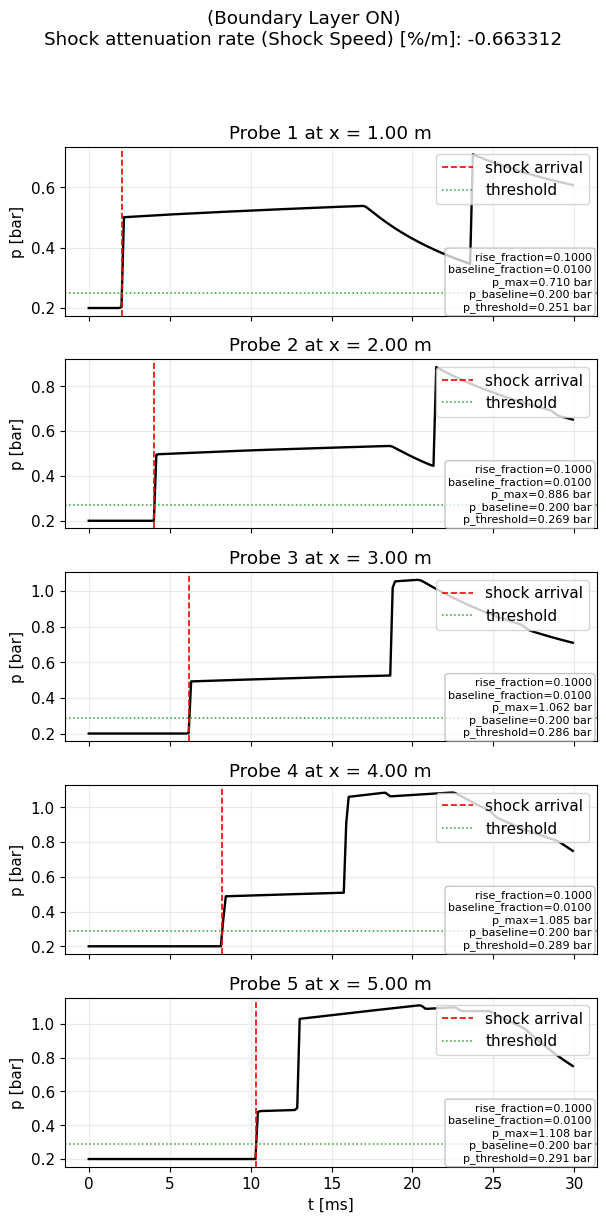

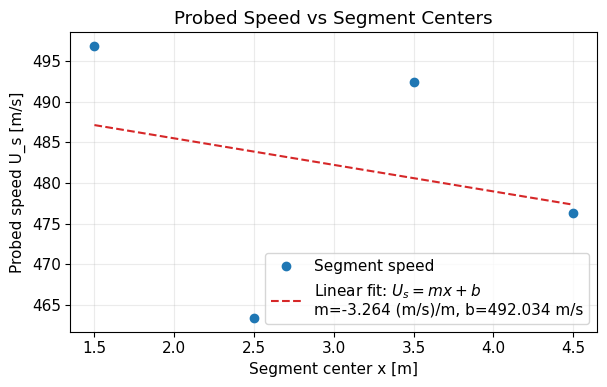

==== Shock Probes (from cache) ====
Probe positions [m]: [1. 2. 3. 4. 5.]
Shock arrival times [ms]: [ 2.04756242  4.06015401  6.21815265  8.24911873 10.34849775]
Shock pressures [bar]: [0.50260545 0.49735885 0.49334652 0.46685548 0.48330598]
Average shock speed from x(t_arrival) [m/s]: 480.938
Segment centers x [m]: [1.5 2.5 3.5 4.5]
Segment shock speeds U_s [m/s]: [496.87179617 463.39232174 492.37651438 476.33133046]


In [88]:
# BLOCK 2: Probe/attenuation/X-t post-processing (no CFD rerun).
# This block loads the cached file from the CFD output folder.
# Edit `probe_locations`, `rise_fraction`, and `baseline_fraction` freely.

cache_dir = 'SOD + BL Simulation Output'
probe_locations = np.linspace(1,5,5)# <-- edit here
rise_fraction = 0.1
baseline_fraction = 0.01  # XX% baseline window = baseline_fraction * 100

cached_metrics = postprocess_cached_results(
    results_location=cache_dir,
    probe_locations=probe_locations,
    rise_fraction=rise_fraction,
    baseline_fraction=baseline_fraction,
    show_results=True,
    boundary_layer_model=None,  # None => use cached CFD BL status
)

print("==== Shock Probes (from cache) ====")
print("Probe positions [m]:", cached_metrics["probe_locations"])
print("Shock arrival times [ms]:", cached_metrics["probe_arrival_times"] * 1e3)
print("Shock pressures [bar]:", cached_metrics["probe_shock_pressures"] / 1e5)
print("Average shock speed from x(t_arrival) [m/s]: %.3f" % cached_metrics["shock_speed_average"])
if len(cached_metrics["shock_speed_segment"]) > 0:
    print("Segment centers x [m]:", cached_metrics["shock_speed_segment_centers"])
    print("Segment shock speeds U_s [m/s]:", cached_metrics["shock_speed_segment"])
